In [51]:
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
from gluonts.model.deepar import DeepAREstimator
from gluonts.trainer import Trainer

In [55]:
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

In [1]:
from src.gluonts_data import MockGluonData, DataFrameGluonWrapper

- test_df start: end of training

In [2]:
mgd = MockGluonData()

In [3]:
wrapped_gloun_data = mgd.get_gluon_wrapped()

In [6]:
full_df = mgd.full_df

In [9]:
break_date = "2017-04-10"

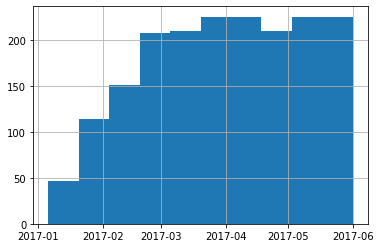

In [10]:
full_df[mgd.date_col].hist()

In [13]:
train_df = full_df.loc[lambda df: df[date_col] < break_date, :]
test_df = full_df.loc[lambda df: df[date_col] >= break_date, :]

In [12]:
train_ds, static_cat_nums = wrapped_gloun_data.get_list_dataset(lambda df: df[mgd.date_col] < break_date)

In [13]:
prediction_length = 6
context_length = 15

In [16]:
estimator = DeepAREstimator(
    prediction_length=prediction_length,
    context_length=context_length,
    freq=wrapped_gloun_data.freq,
    use_feat_dynamic_real=len(wrapped_gloun_data.dynamic_real_cols) > 0,
    use_feat_static_cat=len(wrapped_gloun_data.static_cat_cols) > 0,
    use_feat_static_real=len(wrapped_gloun_data.static_real_cols) > 0,
    cardinality=static_cat_nums,
    scaling=True,
    trainer=Trainer(ctx="cpu",
                    epochs=15,
                    learning_rate=1e-3,
                    hybridize=False,
                    num_batches_per_epoch=100,
                   )
)

In [ ]:
predictor = estimator.train(train_ds)

In [24]:
from tqdm.notebook import tqdm

In [19]:
preds = wrapped_gloun_data.get_rolling_preds(
    break_date,
    full_df[mgd.date_col].max(),
    predictor=predictor,
    date_col=wrapped_gloun_data.date_col,
    wrapper=tqdm
)

In [ ]:
corrs_df = pd.DataFrame(
    {
        startfix: [
            wrapped_gloun_data.get_rolling_preds(
                break_date,
                full_df[mgd.date_col].max(),
                predictor=predictor,
                fixed_start=startfix,
                date_col=wrapped_gloun_data.date_col,
                wrapper=tqdm,
            )
            .corr()
            .iloc[0, 1]
            for _ in tqdm(list(range(20)))
        ]
    for startfix in [True, False]}
)

In [40]:
corrs_df.agg(["mean", "std"])

,True,False
mean,0.331117,0.263546
std,0.000574,0.000724


In [44]:
def plot_prob_forecasts(ts_entry, forecast_entry):
    plot_length = 50
    prediction_intervals = (50.0, 90.0)
    legend = ["observations", "median prediction"] + [
        f"{k}% prediction interval" for k in prediction_intervals
    ][::-1]

    fig, ax = plt.subplots(1, 1, figsize=(15, 7))
    ts_entry[-plot_length:].plot(ax=ax)  # plot the time series
    forecast_entry.plot(prediction_intervals=prediction_intervals, color="g")
    plt.grid(which="both")
    plt.legend(legend, loc="upper left")
    plt.show()

In [45]:
test_ds, _ = wrapped_gloun_data.get_list_dataset()

In [48]:
forecast_it, ts_it = make_evaluation_predictions(
    dataset=test_ds,  # test dataset
    predictor=predictor,  # predictor
    num_samples=500,   # number of sample paths we want for evaluation
)

In [49]:
forecasts = list(forecast_it)
tss = list(ts_it)

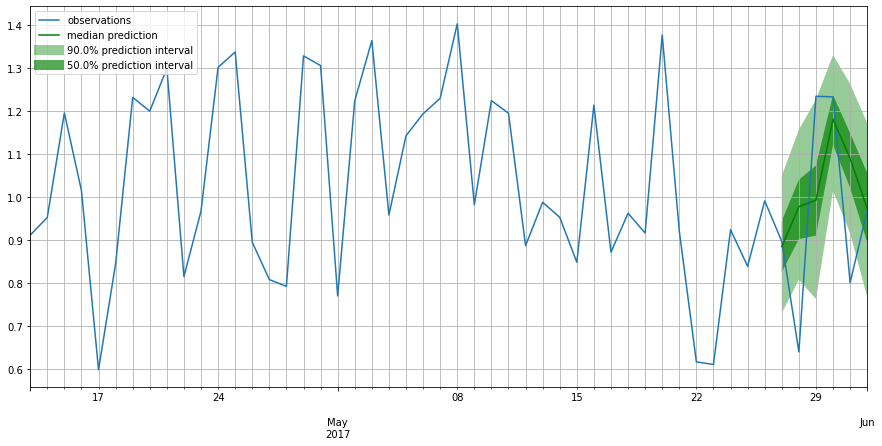

In [52]:
forecast_ind = 1
ts_entry = tss[forecast_ind]
forecast_entry = forecasts[forecast_ind]
plot_prob_forecasts(ts_entry, forecast_entry)

In [56]:
evaluator = Evaluator(quantiles=[0.1, 0.5, 0.9])

In [57]:
agg_metrics, item_metrics = evaluator(iter(tss), iter(forecasts), num_series=len(tss))

Running evaluation: 100%|██████████| 15/15 [00:00<00:00, 359.16it/s]


In [58]:
agg_metrics

{'MSE': 0.06222622808482911,
 'abs_error': 17.866883754730225,
 'abs_target_sum': 93.69328212738037,
 'abs_target_mean': 1.0410364680820041,
 'seasonal_error': 0.22219205798210923,
 'MASE': 0.9621548131276303,
 'MAPE': 0.20929744828810384,
 'sMAPE': 0.20460356406330166,
 'OWA': nan,
 'MSIS': 10.571836200457467,
 'QuantileLoss[0.1]': 8.871156758069993,
 'Coverage[0.1]': 0.17777777777777773,
 'QuantileLoss[0.5]': 17.866883724927902,
 'Coverage[0.5]': 0.3777777777777778,
 'QuantileLoss[0.9]': 9.647515428066253,
 'Coverage[0.9]': 0.7,
 'RMSE': 0.24945185524431185,
 'NRMSE': 0.2396187481346351,
 'ND': 0.19069546235384693,
 'wQuantileLoss[0.1]': 0.09468295438737266,
 'wQuantileLoss[0.5]': 0.19069546203576307,
 'wQuantileLoss[0.9]': 0.1029691265906344,
 'mean_wQuantileLoss': 0.12944918100459005,
 'MAE_Coverage': 0.13333333333333333}

In [59]:
import lightgbm as lgbm
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [60]:
base_shift = mgd.base_shift

In [61]:
tree_df = (
    mgd.full_df.groupby(mgd.static_cat_cols)
    .apply(
        lambda df: pd.concat(
            [
                df.loc[:, [mgd.target_col, mgd.date_col]],
                *[
                    df.drop(mgd.date_col, axis=1)
                    .shift(base_shift + p)
                    .rename(columns=lambda s: f"LAG_{p}_{s}")
                    for p in range(3)
                ],
            ],
            axis=1,
        )
    )
    .dropna()
)

In [63]:
tree_train_df = tree_df.loc[lambda df: df[mgd.date_col] < break_date, :]
tree_test_df = tree_df.loc[lambda df: df[mgd.date_col] >= break_date, :]

In [64]:
tree_model = lgbm.LGBMRegressor().fit(
    tree_train_df.drop([mgd.target_col, mgd.date_col], axis=1), tree_train_df.loc[:, mgd.target_col]
)

In [65]:
test_pred = tree_model.predict(tree_test_df.drop([mgd.target_col, mgd.date_col], axis=1))

In [67]:
mean_absolute_error(test_pred, tree_test_df.loc[:, mgd.target_col]), mean_squared_error(
    test_pred, tree_test_df.loc[:, mgd.target_col]
)

(0.1508798297558998, 0.034997209954544854)

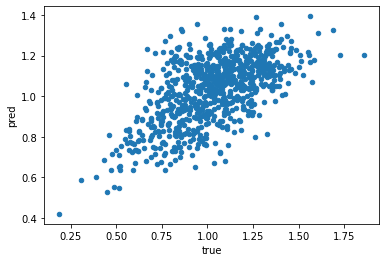

In [68]:
pd.DataFrame(
    {"pred": test_pred, "true": tree_test_df.loc[:, mgd.target_col].values}
).plot.scatter(x="true", y="pred")

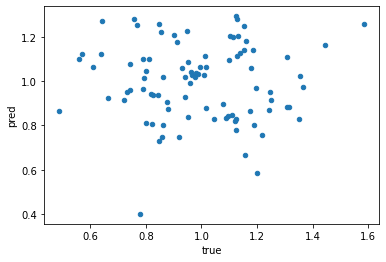

In [69]:
pd.concat(
    [
        pd.DataFrame(
            {
                "pred": fc.samples.mean(axis=0),
                "true": truevals.loc[break_date:, :]
                .iloc[:prediction_length, :]
                .values[:, 0],
            }
        )
        for fc, truevals in zip(forecasts, tss)
        if truevals.index[-prediction_length] > pd.Timestamp(break_date)
    ]
).plot.scatter(x="true", y="pred")